### The cell installs three essential Python libraries—requests, beautifulsoup4, and pandas—to enable data collection, web scraping, and data analysis. This setup step ensures the environment is ready for retrieving online content (e.g., sentiment data), extracting relevant information, and performing structured analysis.

In [1]:
pip install requests beautifulsoup4 pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
# VugaFare: Rwanda Distance-Based Fare System - Sentiment Analysis Pipeline

# Let start by installing all libraries required for our model to run seamlessly.

import pandas as pd
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import plotly.express as px
import seaborn as sns

## Data Loading

## Data Collection Methodology

Our system currently utilizes data gathered through multiple input channels including Google Forms, WhatsApp messaging, and USSD protocols. This data has been securely stored in our database for analysis and system operations.

⚠️ Important Note: For the Rwandan market context, comprehensive authentic datasets are currently limited in availability. While we continue to explore additional data acquisition channels, we have implemented a synthetic dataset for system validation and functional testing purposes. When real-world data becomes accessible, our flexible architecture will seamlessly integrate it without significant system modifications.

In [3]:
# The following code line helps to load datset given or saved after collection.
df = pd.read_csv("/kaggle/input/fareware/NewDataset.csv", parse_dates=['Date'])

# Rename columns for consistency of our dataset use.
df.rename(columns={
    'Name': 'name',
    'District': 'district',
    'Sentiment': 'sentiment',
    'Comments': 'text',
    'Date': 'date'
}, inplace=True)

### Dataset Sample Review

Below is a representative sample of our dataset, provided for review and to inform upcoming analytical activities. This sample illustrates the data structure, key variables, and quality characteristics that will guide our subsequent processing steps.

In [4]:
df.head(10)

,date,name,district,text,Source,sentiment
0,2023-05-01,Lisa French,Gasabo,I'm not happy with the new system.,USSD,Negative
1,2023-05-01,Angela Meyer,Nyarugenge,I'm not happy with the new system.,Facebook,Negative
2,2023-05-03,Jack Turner,Gasabo,I love the new fare system!,Facebook,Positive
3,2023-05-03,Mitchell Williams,Nyarugenge,I think the government made a good decision.,Twitter,Positive
4,2023-05-04,Cassandra Decker,Nyarugenge,"The new system is okay, but I think it's unfair.",Facebook,Neutral
5,2023-05-07,Timothy Moore,Kicukiro,I think the government made a good decision.,WhatsApp,Positive
6,2023-05-09,Brittany Massey,Gasabo,I love the new fare system!,WhatsApp,Positive
7,2023-05-09,Deborah Green,Kicukiro,I think the government made a good decision.,WhatsApp,Positive
8,2023-05-09,Thomas Conway,Gasabo,"The new system is okay, but I think it's unfair.",Facebook,Neutral
9,2023-05-09,Melissa Cunningham,Gasabo,"The new system is okay, but I think it's unfair.",Facebook,Neutral


### Data Cleaning and Normalization 

To prepare text data for analysis, a cleaning function was applied to remove URLs, special characters, and inconsistent casing. This standardization improves the quality and reliability of NLP tasks like sentiment analysis. The cleaned text was stored in a new column to preserve the original data.

In [5]:
#Now we clean data and do normalization
def clean_text(text):
    text = str(text)
    text = re.sub(r"http\S+|www\S+|\n", "", text)
    text = re.sub(r"[^A-Za-z\s]", "", text)
    return text.lower()

df['clean_text'] = df['text'].apply(clean_text)


### Exploratory Data Analysis (EDA)

This Exploratory Data Analysis (EDA) function provides an overview of the dataset by:

- Displaying the total number of comments.

- Showing how comments are distributed across different districts.

- Indicating the time range of the data.

It also visualizes comment frequency per district using a bar chart, helping identify which areas had the most public engagement. This aids in understanding geographic sentiment distribution and guiding further analysis focus.

In [6]:
def perform_eda():
    print("\n--- EDA ---")
    print(f"Total comments: {len(df)}")
    print("Comments per district:\n", df['district'].value_counts())
    print("Date range:", df['date'].min(), "to", df['date'].max())
    
    # Plot frequency of comments per district
    district_counts = df['district'].value_counts().reset_index()
    district_counts.columns = ['District', 'Count']
    fig = px.bar(district_counts, x='District', y='Count', title='Comments per District')
    fig.show() 


### Sentiment Classification using Machine Learning.

A simple sentiment analysis model was trained using labeled examples to classify public comments as Positive, Negative, or Neutral. Texts were cleaned, vectorized, and fed into a logistic regression model. The model enables quick sentiment predictions, with an option to retrieve confidence scores for more reliable insights.

In [7]:
def train_sentiment_classifier():
    
    # Use a richer set of training examples for better prediction
    labeled_data = pd.DataFrame({
        'text': [
            "I love the new fare system",
            "The transport cost is very affordable now",
            "This fare system is terrible",
            "I hate the new changes",
            "The pricing system is confusing",
            "Great initiative for fair pricing",
            "Too expensive for short distances",
            "Everything is clear now",
            "They never explained anything well",
            "It's okay, but not perfect"
        ],
        'sentiment': [
            'Positive', 'Positive', 'Negative', 'Negative', 'Neutral',
            'Positive', 'Negative', 'Positive', 'Negative', 'Neutral'
        ]
    })
    labeled_data['clean_text'] = labeled_data['text'].apply(clean_text)
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(labeled_data['clean_text'])
    model = LogisticRegression()
    model.fit(X, labeled_data['sentiment'])
    return model, vectorizer


def predict_sentiment(texts, model, vectorizer):
    X = vectorizer.transform(texts)
    return model.predict(X)

def predict_sentiment_with_scores(texts, model, vectorizer):
    X = vectorizer.transform(texts)
    probs = model.predict_proba(X)
    preds = model.predict(X)
    scores = probs.max(axis=1)
    return preds, scores

## Topic modeling

This approach helps summarize large text datasets by uncovering common topics without manual labeling, guiding focused analysis or decision-making.

In [8]:
def extract_topics(texts, n_topics=3, n_words=6):
    tfidf = TfidfVectorizer(max_df=0.9, min_df=2, stop_words='english')
    dtm = tfidf.fit_transform(texts)
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(dtm)
    print("\n--- Top Concerns (Topics) ---")
    for idx, topic in enumerate(lda.components_):
        print(f"Topic {idx+1}: ", [tfidf.get_feature_names_out()[i] for i in topic.argsort()[-n_words:]])

In [9]:
def assign_topics(texts, n_topics=3):
    tfidf = TfidfVectorizer(max_df=0.9, min_df=2, stop_words='english')
    dtm = tfidf.fit_transform(texts)
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(dtm)
    topic_keywords = []
    for topic in lda.components_:
        keywords = [tfidf.get_feature_names_out()[i] for i in topic.argsort()[-5:]]
        topic_keywords.append(", ".join(keywords))
    topic_labels = [f"Topic {i+1}: {kw}" for i, kw in enumerate(topic_keywords)]
    topic_assignments = lda.transform(dtm).argmax(axis=1)
    return topic_assignments, topic_labels


## Misinformation Flagging (Heuristic)

This function flags comments that potentially contain misinformation by checking for specific keywords such as "fake," "lie," or "scam." It scans each text for these indicators and marks those that include any of the keywords. This simple keyword-based approach helps quickly identify and filter out dubious or misleading content for further review.

In [10]:
def flag_misinformation(texts):
    keywords = ["fake", "lie", "scam", "not true", "misinformation", "rumor"]
    def is_misinformed(text):
        return any(word in text for word in keywords)
    return texts.apply(is_misinformed)

## General Visualization 

This function generates multiple visualizations to better understand public sentiment and discussion patterns:

- Pie chart showing the overall distribution of predicted sentiments (Positive, Negative, Neutral), giving a quick snapshot of general opinion.

- Line chart tracking sentiment trends over time, helping identify how public sentiment evolves.

- Word cloud highlighting the most frequent words in the cleaned comments, providing a visual summary of key topics and themes.

Together, these visual tools make it easier to interpret large text datasets and communicate insights effectively.

In [11]:
def generate_visualizations():
    sentiment_counts = df['PredictedSentiment'].value_counts().reset_index()
    sentiment_counts.columns = ['Sentiment', 'Count']
    fig1 = px.pie(sentiment_counts, names='Sentiment', values='Count',
                  title='Overall Sentiment Distribution')
    fig1.show()

    # Time series trend
    daily_sentiment = df.groupby(['date', 'PredictedSentiment']).size().unstack().fillna(0)
    fig2 = px.line(daily_sentiment, title='Sentiment Trend Over Time')
    fig2.show()

    # Word Cloud 
    all_words = ' '.join(df['clean_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Word Cloud of Public Comments")
    plt.show()

In [12]:
def generate_report():
    print("\n--- Sample Public Feedback ---")
    print(df[['date', 'district', 'name', 'text', 'PredictedSentiment', 'Misinformation']].head(10).to_string(index=False))
    
    misinfo_rate = df['Misinformation'].mean() * 100
    print(f"\n⚠️ Estimated Misinformation Rate: {misinfo_rate:.2f}%")
    
    print("\n✅ Policy Recommendations:")
    print("- Increase public awareness on fare calculation.")
    print("- Provide visual explanations (charts/posters) in buses.")
    print("- Address frequently mentioned concerns (e.g., fairness, price inconsistency).")
    print("- Launch FAQ portal to counter misinformation.")

## Main function 

The main() function orchestrates the entire sentiment analysis workflow on public comments about Rwanda’s transport fare reform:

- Starts with basic exploratory data analysis (EDA) to understand the dataset.

- Trains a sentiment classifier and predicts sentiments for all comments.

- Extracts key discussion topics using topic modeling.

- Flags comments containing potential misinformation.

- Predicts sentiment along with confidence scores to assess prediction reliability.

- Displays sample predictions with scores for validation.

- Generates various visualizations to summarize sentiment distribution and trends.

- Produces a comprehensive report for further insights.

- Assigns topic labels to each comment for thematic categorization.

This structured pipeline ensures a thorough, interpretable, and actionable analysis of public sentiment, supporting data-driven decision-making for policy evaluation and communication.

🇷🇼 VugaFare - Public Sentiment Analysis on Transport Fare Reform

--- EDA ---
Total comments: 150
Comments per district:
 district
Gasabo        55
Kicukiro      51
Nyarugenge    44
Name: count, dtype: int64
Date range: 2023-05-01 00:00:00 to 2023-07-31 00:00:00



--- Top Concerns (Topics) ---
Topic 1:  ['happy', 'new', 'think', 'decision', 'good', 'government']
Topic 2:  ['im', 'love', 'new', 'think', 'okay', 'unfair']
Topic 3:  ['im', 'complicated', 'distancebased', 'new', 'love', 'fare']

--- Sample Predicted Sentiments with Confidence Scores ---
                                              text PredictedSentiment  SentimentScore
  The new system is okay, but I think it's unfair.            Neutral        0.550270
The distance-based fare system is too complicated.           Negative        0.425247
The distance-based fare system is too complicated.           Negative        0.425247
  The new system is okay, but I think it's unfair.            Neutral        0.550270
      I think the government made a good decision.           Negative        0.407743
                I'm not happy with the new system.           Positive        0.382057
The distance-based fare system is too complicated.           Negative        0.425247
                    

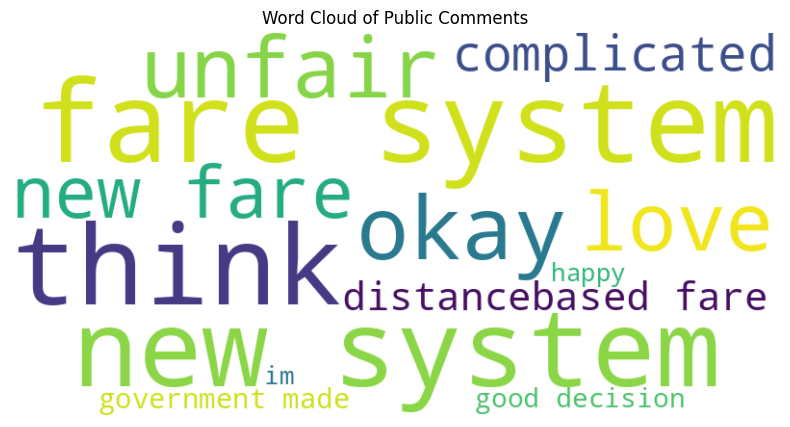


--- Sample Public Feedback ---
      date   district               name                                             text PredictedSentiment  Misinformation
2023-05-01     Gasabo        Lisa French               I'm not happy with the new system.           Positive           False
2023-05-01 Nyarugenge       Angela Meyer               I'm not happy with the new system.           Positive           False
2023-05-03     Gasabo        Jack Turner                      I love the new fare system!           Positive           False
2023-05-03 Nyarugenge  Mitchell Williams     I think the government made a good decision.           Negative           False
2023-05-04 Nyarugenge   Cassandra Decker The new system is okay, but I think it's unfair.            Neutral           False
2023-05-07   Kicukiro      Timothy Moore     I think the government made a good decision.           Negative           False
2023-05-09     Gasabo    Brittany Massey                      I love the new fare system!    

In [13]:

def main():
    print("🇷🇼 VugaFare - Public Sentiment Analysis on Transport Fare Reform")

    perform_eda()
    
    # Train model & predict sentiment
    model, vectorizer = train_sentiment_classifier()
    df['PredictedSentiment'] = predict_sentiment(df['clean_text'], model, vectorizer)

    # Extract key topics
    extract_topics(df['clean_text'])

    # Flag misinformation
    df['Misinformation'] = flag_misinformation(df['clean_text'])

    # Predict sentiment with scores
    preds, scores = predict_sentiment_with_scores(df['clean_text'], model, vectorizer)
    df['PredictedSentiment'] = preds
    df['SentimentScore'] = scores

    # Show top 10 examples with scores
    print("\n--- Sample Predicted Sentiments with Confidence Scores ---")
    print(df[['text', 'PredictedSentiment', 'SentimentScore']].sample(10).to_string(index=False))


    # Visual analysis
    generate_visualizations()

    # Report
    generate_report()

    # Assign topics to comments
    df['TopicID'], topic_labels = assign_topics(df['clean_text'])
    df['TopicLabel'] = df['TopicID'].apply(lambda x: topic_labels[x])


if __name__ == '__main__':
    main()


In [14]:
# Group the data by district and predicted sentiment
sentiment_by_district = df.groupby(['district', 'PredictedSentiment']).size().unstack(fill_value=0)

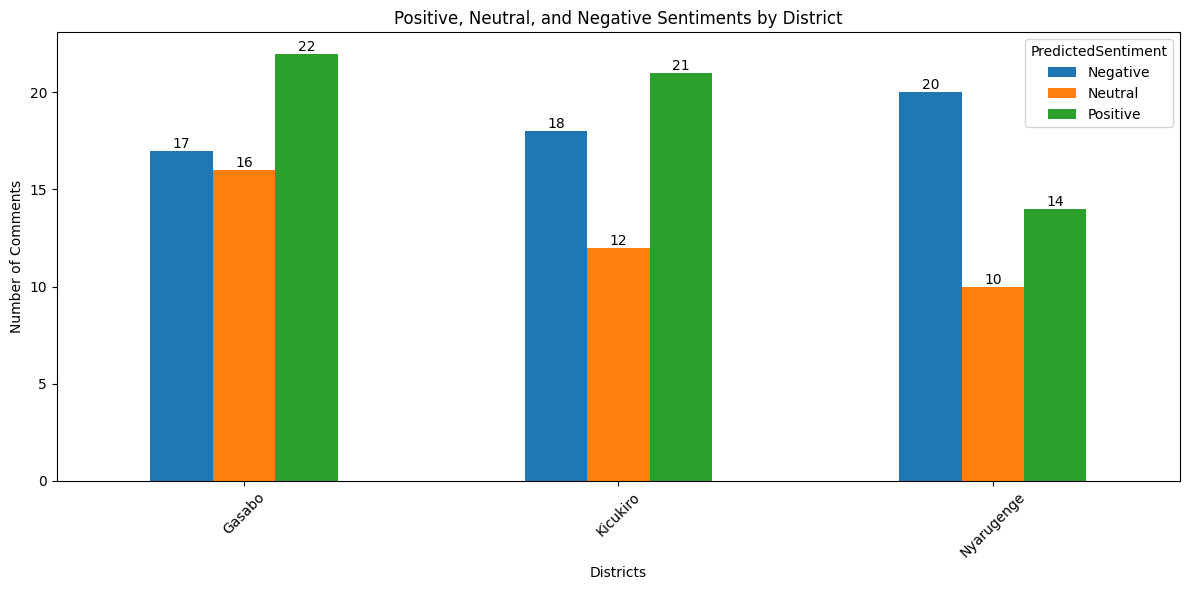

In [15]:
# Group the data by district and predicted sentiment
sentiment_by_district = df.groupby(['district', 'PredictedSentiment']).size().unstack(fill_value=0)

# Plot the grouped data
ax = sentiment_by_district.plot(kind='bar', figsize=(12, 6), title="Positive, Neutral, and Negative Sentiments by District")
plt.ylabel("Number of Comments")
plt.xlabel("Districts")
plt.xticks(rotation=45)
plt.tight_layout()

# Add value labels on top of bars
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}', 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='bottom', fontsize=10)

plt.show()


The visualization reveals distinct sentiment patterns across three Rwandan districts. Gasabo shows the most positive outlook (22 positive vs. 17 negative comments) with a balanced distribution including substantial neutral feedback (16).
Kicukiro maintains positive dominance (21 positive vs. 18 negative) with moderate neutral sentiment (12). In contrast, Nyarugenge displays concerning trends with negative sentiment prevailing (20 negative vs. 14 positive) and minimal neutral responses (10).
This geographic gradient suggests targeted interventions are needed in Nyarugenge to address underlying issues, while Gasabo's more balanced sentiment profile could provide valuable insights for improvement strategies across all districts.

In [16]:
# Ensure 'date' column is datetime
df['date'] = pd.to_datetime(df['date'])

# Set date as index for resampling
df.set_index('date', inplace=True)

# Resample by 4-day intervals and count sentiment occurrences
sentiment_trend = df.resample('4D')['PredictedSentiment'].value_counts().unstack().fillna(0)

# Reset index for plotting
sentiment_trend = sentiment_trend.reset_index()

# Plot with Plotly
import plotly.express as px
import pandas as pd

# Melt dataframe for long format
sentiment_trend_long = sentiment_trend.melt(id_vars='date', 
                                             value_vars=['Positive', 'Negative', 'Neutral'], 
                                             var_name='Sentiment', 
                                             value_name='Count')

# Line plot
fig = px.line(sentiment_trend_long, x='date', y='Count', color='Sentiment',
              title='Sentiment Trend Over Time (4-Day Intervals)',
              markers=True)

fig.update_layout(xaxis_title='Date', yaxis_title='Number of Comments')
fig.show()

The above graph shows the sentiment Trend over time just with four days in between

In [17]:
def visualize_sentiment_by_topic():
    grouped = df.groupby(['TopicLabel', 'PredictedSentiment']).size().reset_index(name='Count')

    fig = px.sunburst(grouped,
                      path=['TopicLabel', 'PredictedSentiment'],
                      values='Count',
                      title='Sentiment Breakdown by Topic',
                      color='PredictedSentiment',
                      color_discrete_map={
                          'Positive': 'green',
                          'Negative': 'yellow',
                          'Neutral': 'gray'
                      })
    fig.show()
    
visualize_sentiment_by_topic()


The visualization reveals distinct sentiment patterns across different topics in the dataset. Positive sentiment (green) dominates one topic category, suggesting areas of public satisfaction. Two separate negative sentiment segments (yellow) appear tied to different topic clusters, indicating specific issue areas driving dissatisfaction.
The inner ring provides topic categorization with Topic 1 labeled as "complicated, disorganized, new, time, rare" and Topic 2 showing similar descriptors. This structure suggests that sentiment is strongly topic-dependent rather than uniformly distributed.
The relatively balanced distribution between positive, negative, and neutral sentiments demonstrates a diverse public opinion landscape, with clear opportunities to address specific topic areas driving negative sentiment while reinforcing successful elements in positively-received topics.

In [18]:
def visualize_sentiment_by_district():
    grouped = df.groupby(['district', 'PredictedSentiment']).size().reset_index(name='Count')

    fig = px.sunburst(grouped,
                      path=['district', 'PredictedSentiment'],
                      values='Count',
                      title='Sentiment Breakdown by District',
                      color='PredictedSentiment',
                      color_discrete_map={
                          'Positive': 'green',
                          'Negative': 'yellow',
                          'Neutral': 'gray'
                      })
    fig.show()
visualize_sentiment_by_district()


## The sunburst visualization:

reveals distinct sentiment patterns across three Rwandan districts. Gasabo and Kicukiro both show strong positive sentiment dominance (green segments), while Nyarugenge displays a concerning negative sentiment majority (yellow segment).
Neutral responses (gray) appear most prominent in Gasabo, moderate in Kicukiro, and minimal in Nyarugenge, suggesting increasing opinion polarization moving from Gasabo to Nyarugenge.
This district-based sentiment breakdown highlights a clear geographic trend: positive sentiment decreases while negative sentiment increases when moving toward Nyarugenge, indicating targeted interventions should prioritize addressing specific concerns in the Nyarugenge district while learning from more successful approaches in Gasabo.

## Read me file for the visualization pie chart, Plot and bar.


From the first output or graph it is clear that Gasabo had the highest number of comments, suggesting higher public engagement or concern in this district.

Kicukiro and Nyarugenge followed closely, with only slight variations in volume.

The differences in comment volume may reflect factors if the dataset is real such as:

- Route coverage and transport frequency

- Population density and commuting patterns

- Access to information or digital platforms

- Socioeconomic differences influencing fare sensitivity etc

### ⚠️ Remember that this is sysnthetic dataset,not real one.

I.  Between May and July 2023, Rwandan citizens actively shared their views about the newly introduced distance-based fare system for public transport. Our analysis of these public comments reveals a mix of opinions, highlighting both appreciation for the modernization and concerns about its fairness and clarity. We used AI-powered sentiment analysis to understand how people feel and grouped the most frequently mentioned words into common themes or "topics" to identify what people care about most.

Three main topics emerged from the analysis. The first topic contains words like “happy,” “decision,” “good,” and “government,” suggesting that some citizens view the new fare model as a positive and well-intentioned step by the authorities. The second topic includes “love,” “okay,” and “unfair,” reflecting mixed reactions while some people see potential in the system, they also express doubts about whether it is applied fairly. The third topic highlights more negative reactions, with words like “complicated,” “distance-based,” and “fare” suggesting that many people find the system confusing or difficult to understand.

Sample sentiment predictions further reinforce these observations. Comments such as “I love the new fare system!” were clearly classified as positive, showing that some citizens embrace the change. However, neutral and negative comments like “The new system is okay, but I think it's unfair” and “The distance-based fare system is too complicated” signal important areas of dissatisfaction. These comments indicate that although people might be open to the change, they are concerned about how the fare is calculated and whether it treats all passengers fairly. Interestingly, even a seemingly supportive comment like “I think the government made a good decision” was classified as negative by the model likely due to the tone or lack of full confidence in the statement which shows how complex and nuanced public sentiment can be.

Overall, the data highlights that while there is some support for the new fare system, many citizens feel that it is unclear or potentially unfair. These perceptions could hinder broader acceptance if not addressed. To improve public confidence and understanding, we recommend that the government and transport agencies develop more transparent communication strategies. This could include simplified fare calculators, infographics in Kinyarwanda and English, and direct engagement with high-comment districts like Gasabo and Kicukiro. Additionally, ongoing public education and feedback mechanisms would help address misconceptions and build trust as the system continues to evolve.

II. The pie chart shows that public opinion on the new distance-based fare system is divided. Positive sentiment leads slightly at 38%, indicating a favorable view among many citizens. However, 36.7% express negative sentiment, pointing to significant concerns around fairness and complexity. A further 25.3% are neutral, suggesting uncertainty or mixed feelings. This highlights the need for clearer communication and ongoing public engagement to improve understanding and trust in the system.

III. From the word cloud highlights the mixed sentiment around the new fare system. Policymakers should recognize that while many users support the system, concerns about fairness and complexity are widespread and need to be addressed through clear communication and system improvements.

A word cloud, also known as a tag cloud, is a visual representation of text data where the size of each word indicates its frequency in the text

#                                                  Thank you!!!!!!!!!!